<font size="6" color="green"><b>PROJECT-3.</b> Анализ воронки (GameDev)</font>

<font size="4" color="green"><b> Цель работы:  </b></font>
Исследование поведения пользователей в мобильной игре <b><i>Quiz Freeze</b></i><br><br>
<font size="4" color="green"><b> Поставленный список вопросов:  </b></font> <br>
* <b> Гипотеза 1:</b>
    По идее, должна быть разница в поведении групп, которые проходят и не проходят обучение. Но так ли это? Влияет ли обучение на скорость прохождения других этапов игры?

* <b> Гипотеза 2: </b>
    Кажется, повторное прохождение обучения положительно влияет на оплату, верно?

* <b> Гипотеза 3: </b>
    Если пользователь сначала выбирает сложность обучения, будет ли он потом проходить обучение?
<font size="3" color="brown" ><p style="text-align:right;"><b>DAPR-1014</b>, Коссе Максим  </p></font>

<font size="4" color="green"><b> КОНКРЕТНЫЕ ШАГИ (ФОРМАЛИЗОВАННЫЕ ЗАДАЧИ)</b></font> <br>
* *Сравнить* время прохождения различных этапов для пользователей, которые завершили обучение, и пользователей, не начинавших обучение. Если показатель отличается, выяснить, насколько.

* *Проверить*, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь. 

* *Выяснить*, как часто пользователи начинают обучение после выбора уровня сложности. (Это позволит оценить прозрачность процесса взаимодействия с игрой: если пользователи после выбора уровня сложности обращаются к обучению, значит, работа с приложением непонятна.)

<font size="4" color="green"><b> Этапы игры </b></font>

**Регистрация** (registration) — это обязательный этап. Без регистрации пользователь не может пройти на следующие этапы работы с приложением.

**Старт обучения** (tutorial start) — опциональный этап. Пользователь после регистрации может перейти к обучению работе с приложением, а может и не перейти. При этом вернуться к обучению можно в любой момент. А ещё можно пройти обучение несколько раз.

**Завершение обучения** (tutorial finish) может произойти только в случае, если ранее произошло событие «Старт обучения», но при этом пользователь может не завершить обучение.

**Выбор уровня сложности вопросов** (level choice) — это обязательное событие, которое нужно для того, чтобы перейти к выбору пакетов вопросов. Таким образом, пользователь может не пройти обучение или даже не начинать его, но прежде чем начать отвечать, он обязан выбрать уровень сложности.

**Выбор пакетов вопросов** (pack choice, другое название training choice) — это этап, на котором пользователь выбирает себе бесплатный набор пакетов вопросов, на которые он будет отвечать.

**Покупка платных пакетов вопросов** (purchase) — это факт совершения оплаты за вопросы, которые не доступны в списке бесплатных вопросов.

## 1. Импорт и загрузка

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Загружаем в датафрейм события - event_df
event_df = pd.read_csv('data/7_4_Events.csv')

# Загружаем в датафрейм записи оплаты контента - purch_df
purch_df = pd.read_csv('data/purchase.csv')

## 2. Очистка и трансформация

### 2.1. Пользователи только 2018 года регистрации

Исполняем условие об ограничении - "*Выполнять задание необходимо на основе данных пользователей, которые зарегистрировались в 2018 году.*"

In [8]:
# Формируем маски для выборки пользователей, зарегистрированных в 2018
musk_A = event_df['event_type'] == 'registration'
musk_B = event_df['start_time'] >= '2018-01-01'
musk_C = event_df['start_time'] <= '2018-12-31'

# Выгружаем ID пользователей, зарегестрированных в 2018г. в список для последующего усечения
usr2018_keeplist = event_df[musk_A & musk_B & musk_C]['user_id'].to_list()

# Урезаем загруженные датасеты, оставляя только данные поколения-2018
event_df = event_df[event_df['user_id'].isin(usr2018_keeplist)]
purch_df = purch_df[purch_df['user_id'].isin(usr2018_keeplist)]

### 2.2. Формирование объединенного датафрейма событий

Собираем события из двух датасетов в единый датафрейм **all_events_df** для удобства последующей обработки.

In [9]:
# Добавим в датафрейм purch_df столбец event_type, который будет содержать одно значение - purchase.
# Это необходимо для идентификации событий оплаты в объединенном датафрейме.

purch_df['event_type'] = 'purchase'

In [10]:
# Переименуем столбцы с именем 'id', которые несут различный смысл в исходных датафреймах. 
# Соответственно в формируемом едином датафрейме: 
#   - колонка event_id будет содержать идентификатор выбора пользователя, NaN для событий оплаты
#   - колонка purchase_id  будет содержать идентификатор оплаты, NaN для остальных событий 

# Также приводим наименование столбца 'event_datetime' из purch_df к единому 'start_time'

event_df = event_df.rename(columns={'id': 'event_id'})
purch_df = purch_df.rename(columns={
        'id': 'purchase_id', 
        'event_datetime': 'start_time'
    })

In [11]:
# Формируем объединенную таблицу событий - all_events_df
all_events_df = pd.concat([event_df,purch_df],sort=False)

# Приведем поле 'start_time' к типу DateTime:
all_events_df['start_time'] = pd.to_datetime(all_events_df['start_time'])

# Проведем сброс индексов после объединения, отсортируем события по времени
all_events_df = all_events_df.reset_index(drop=True).sort_values('start_time')

# Проверим содержимое полученной таблицы
display(all_events_df.describe(include='all')) # Устаревший аргумент datetime_is_numeric=True изъят

,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,amount
count,66929.000000,68529,8338,68529,32942.000000,68529.000000,1600.000000,1600.000000
unique,NaN,6,3,NaN,NaN,NaN,NaN,NaN
top,NaN,registration,medium,NaN,NaN,NaN,NaN,NaN
freq,NaN,19914,4642,NaN,NaN,NaN,NaN,NaN
mean,113772.001016,NaN,NaN,2018-07-03 07:09:43.450072064,40529.649323,37776.506734,17645.505625,110.734375
min,80308.000000,NaN,NaN,2018-01-01 03:48:40,31505.000000,27832.000000,16845.000000,25.000000
25%,97040.000000,NaN,NaN,2018-03-24 12:27:51,36007.000000,32845.000000,17245.750000,50.000000
50%,113772.000000,NaN,NaN,2018-06-23 18:35:11,40526.500000,37711.000000,17645.500000,100.000000
75%,130504.000000,NaN,NaN,2018-10-12 11:09:19,45052.000000,42735.000000,18045.250000,150.000000
max,147241.000000,NaN,NaN,2019-01-06 07:14:25,49549.000000,47745.000000,18452.000000,300.000000


## 3. Гипотеза 1. Влияние факта завершения обучения на время прохождения этапов игры.

*Сравнить* время прохождения различных этапов для пользователей, которые завершили обучение, и пользователей, не начинавших обучение. Если показатель отличается, выяснить, насколько.

### 3.1. Категорирование пользователей по прохождению обучения

Для классификации пользователей по признаку прохождения обучения сформируем таблицу вида "пользователи - время игровых событий (по самомому раннему проявлению)". Далее, на основании анализа таймингов событий у каждого пользователя, присвоим ему соответствующий признак tutorial_status (complete, incomplete, skipped). 

In [12]:
# Формируем сводную таблицу вида: 
#   - строки: идентификатор пользователя
#   - столбцы: тип игрового события
#   - значения: время самого раннего проявления события
# Также сразу сбросим индекс, для формирования столбца из индекса user_id

pvt_id_vs_timing = all_events_df.pivot_table(
    index = 'user_id',
    columns = 'event_type',
    values = 'start_time',
    aggfunc = 'min'
).reset_index()

# вывод для проверки результата
display(pvt_id_vs_timing.info())
display(pvt_id_vs_timing.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19914 entries, 0 to 19913
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   user_id          19914 non-null  int64         
 1   level_choice     8338 non-null   datetime64[ns]
 2   pack_choice      5735 non-null   datetime64[ns]
 3   purchase         1600 non-null   datetime64[ns]
 4   registration     19914 non-null  datetime64[ns]
 5   tutorial_finish  10244 non-null  datetime64[ns]
 6   tutorial_start   11852 non-null  datetime64[ns]
dtypes: datetime64[ns](6), int64(1)
memory usage: 1.1 MB


None

event_type,user_id,level_choice,pack_choice,purchase,registration,tutorial_finish,tutorial_start
0,27832,NaT,NaT,NaT,2018-01-01 03:48:40,NaT,NaT
1,27833,NaT,NaT,NaT,2018-01-01 04:07:25,2018-01-01 17:50:08,2018-01-01 17:47:40
2,27834,NaT,NaT,NaT,2018-01-01 08:35:10,2018-01-01 19:48:01,2018-01-01 19:46:11
3,27835,2018-01-01 20:37:22,2018-01-01 20:38:43,NaT,2018-01-01 11:54:47,2018-01-01 15:06:15,2018-01-01 15:00:51
4,27836,NaT,NaT,NaT,2018-01-01 13:28:07,2018-01-01 15:42:58,2018-01-01 14:54:40


У нас имеется значительное количество "мертвых душ", зарегистрированных в игре, но не начинавших ее. Поскольку для проверки гипотез они не дают какой-либо ценной информации, доочистим данные от этой категории по признаку level_choice.

In [13]:
# инициализируем маску поиска начинавших игру
musk_A = pvt_id_vs_timing['level_choice'].notna()

# доочистим датафрейм от неактивных игроков
pvt_id_vs_timing = pvt_id_vs_timing[musk_A].reset_index()

# вывод для проверки результата
display(pvt_id_vs_timing.info())
display(pvt_id_vs_timing.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8338 entries, 0 to 8337
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   index            8338 non-null   int64         
 1   user_id          8338 non-null   int64         
 2   level_choice     8338 non-null   datetime64[ns]
 3   pack_choice      5735 non-null   datetime64[ns]
 4   purchase         1600 non-null   datetime64[ns]
 5   registration     8338 non-null   datetime64[ns]
 6   tutorial_finish  7497 non-null   datetime64[ns]
 7   tutorial_start   8240 non-null   datetime64[ns]
dtypes: datetime64[ns](6), int64(2)
memory usage: 521.3 KB


None

event_type,index,user_id,level_choice,pack_choice,purchase,registration,tutorial_finish,tutorial_start
0,3,27835,2018-01-01 20:37:22,2018-01-01 20:38:43,NaT,2018-01-01 11:54:47,2018-01-01 15:06:15,2018-01-01 15:00:51
1,7,27839,2018-01-01 22:37:50,2018-01-01 22:42:54,NaT,2018-01-01 18:24:01,2018-01-01 19:16:32,2018-01-01 19:11:36
2,8,27840,2018-01-02 05:18:42,NaT,NaT,2018-01-01 20:53:21,NaT,2018-01-02 02:07:07
3,10,27842,2018-01-02 08:46:03,NaT,NaT,2018-01-01 23:18:46,2018-01-02 04:57:01,2018-01-02 04:55:11
4,11,27843,2018-01-02 14:09:58,2018-01-02 14:14:51,NaT,2018-01-02 00:02:28,2018-01-02 13:38:23,2018-01-02 13:34:51


In [14]:
# Создаем множества id пользователей по их отношению к прохождению обучения. 
# На основании принадлежности пользователя к множеству далее будем ему присваивать соответствующий статус.

# set_users_tutorial_complete - множество id пользователей, закончивших обучение
set_users_tutorial_complete = set(
    all_events_df[all_events_df.event_type == 'tutorial_finish'].user_id
)

# set_users_tutorial_incomplete - множество id пользователей, начавших и не закончивших обучение
set_users_tutorial_incomplete = set(
    all_events_df[all_events_df.event_type == 'tutorial_start'].user_id
)

# set_users_tutorial_skipped - множество id пользователей, не начинавших обучение.
# формируем его, вычитая из множества всех пользователей множество начавших обучение
set_users_tutorial_skipped = set(all_events_df.user_id) - set_users_tutorial_incomplete

In [15]:
# Определяем функцию, возвращающую статус пользователя, на основании принадлежности множествам, определенным выше
def user_tutorial_status(user_id: int):
    if user_id in set_users_tutorial_complete: 
        return 'complete'
    elif user_id in set_users_tutorial_incomplete: 
        return 'incomplete'
    else: 
        return 'skipped'

In [16]:
# Создаем новый столбец с признаком tutorial_status в сводной таблице pvt_id_vs_timing, 
# применив функцию user_tutorial_status() к столбцу user_id:

pvt_id_vs_timing['tutorial_status'] = pvt_id_vs_timing.user_id.apply(user_tutorial_status)

Удаляем информацию по начавшим, но не закончившим обучение, поскольку эта группа не дает информации для проверки гипотезы.

In [17]:
pvt_id_vs_timing = pvt_id_vs_timing[pvt_id_vs_timing['tutorial_status'] != 'incomplete']

### 3.2. Нахождение временных интервалов по этапам игры

Определимся с интервалами времени, по которым поведем сравнительный анализ. <br>
Очевидно, что группы "прошедшие обучение" и "не начавшие обучение" будут отличаться временем, потраченным в игре на прохождения обучения, у последних оно нулевое. 
Анализировать эту разницу нет смысла, засим предлагается:
 - не рассматривать временные интервалы, связанные со стартом и завершением обучения;
 - первым интервалом считать время от регистрации до выбора сложности;
 - нормализовать время выполнения первого интервала для "обученных", вычитая из него время, потраченное на обучение.

Таким образом, далее будем сравнивать 3 временных интервала:
- от регистрации до выбора уровня сложности (нормализованное);
- от выбора уровня до выбора пакета вопросов;
- от выбора пакета вопросов до оплаты дополнительного контента.

In [18]:
# Рассчитаем полную длительность 1 периода от регистрации до выбора уровня; приведем к значению в часах

one_hour = pd.Timedelta('1 hour')

pvt_id_vs_timing['level_choice_delay'] = \
    (pvt_id_vs_timing.level_choice - pvt_id_vs_timing.registration) / one_hour

# найдем время обучения, в часах
pvt_id_vs_timing['tutorial_duration'] = \
    (pvt_id_vs_timing.tutorial_finish - pvt_id_vs_timing.tutorial_start) / one_hour
# для пропустивших обучение, его время установим равным нулю
pvt_id_vs_timing['tutorial_duration'] = pvt_id_vs_timing['tutorial_duration'].fillna(0)

# найдем нормализованную длительность 1 периода от регистрации до выбора уровня
pvt_id_vs_timing['level_choice_delay'] = \
    pvt_id_vs_timing.level_choice_delay - pvt_id_vs_timing.tutorial_duration

In [19]:
# вычисляем длительность 2 периода от выбора уровня сложности до выбора бесплатных пакетов вопросов, в часах
pvt_id_vs_timing['pack_choice_delay'] = \
    (pvt_id_vs_timing.pack_choice - pvt_id_vs_timing.level_choice) / one_hour

# вычисляем длительность 3 периода от выбора бесплатных пакетов вопросов до покупки дополнительного контента, в часах
pvt_id_vs_timing['purchase_delay'] = \
    (pvt_id_vs_timing.purchase - pvt_id_vs_timing.pack_choice) / one_hour

In [20]:
# проверим полученную таблицу на адекватность результатов 
pvt_id_vs_timing.describe()

event_type,index,user_id,level_choice,pack_choice,purchase,registration,tutorial_finish,tutorial_start,level_choice_delay,tutorial_duration,pack_choice_delay,purchase_delay
count,7595.000000,7595.000000,7595,5248,1469,7595,7497,7497,7595.000000,7595.000000,5248.000000,1469.000000
mean,9981.395523,37813.395523,2018-07-03 23:54:01.847267840,2018-07-04 17:28:02.698932992,2018-07-06 01:27:50.485364224,2018-07-03 16:49:49.669782784,2018-07-03 23:23:43.431906048,2018-07-03 23:11:00.778711552,6.860935,0.209115,0.088397,89.472517
min,3.000000,27835.000000,2018-01-01 20:37:22,2018-01-01 20:38:43,2018-01-03 18:53:43,2018-01-01 11:54:47,2018-01-01 15:06:15,2018-01-01 15:00:51,0.071667,0.000000,0.005278,0.747222
25%,5019.000000,32851.000000,2018-03-24 14:15:39.500000,2018-03-25 04:48:37.750000128,2018-03-27 17:20:47,2018-03-24 09:23:01.500000,2018-03-24 10:30:03,2018-03-24 10:28:43,3.690833,0.040833,0.051389,45.402222
50%,9865.000000,37697.000000,2018-06-23 18:34:44,2018-06-25 12:56:19,2018-06-26 00:55:06,2018-06-23 15:04:08,2018-06-23 17:57:05,2018-06-23 17:37:33,5.786667,0.062778,0.082778,84.503611
75%,15003.500000,42835.500000,2018-10-14 01:03:51.500000,2018-10-15 17:40:31.750000128,2018-10-20 05:31:44,2018-10-13 15:36:35.500000,2018-10-13 22:47:45,2018-10-13 22:41:05,9.095000,0.088333,0.119722,129.131944
max,19912.000000,47744.000000,2018-12-31 09:59:00,2018-12-31 10:05:18,2019-01-06 07:14:25,2018-12-30 22:12:24,2018-12-31 07:21:02,2018-12-31 07:14:38,42.750000,18.908056,0.263333,258.566389
std,5768.918022,5768.918022,NaN,NaN,NaN,NaN,NaN,NaN,4.438245,1.079719,0.045740,52.540439


Явных аномалий нет, однако длительность первого этапа довольно значительная, в среднем почти 7 часов, медиана около 6 часов. Пользователи неохотно приступают к игровому процессу.

In [21]:
# На основании длительностей этапов по пользователям формируем сводную таблицу
# для групп пользователей "прошедшие обучение" / "не начинавшие обучение",
# со средними значениями времени прохождения этапов игры. 
pvt_tutorial_vs_time = pvt_id_vs_timing.pivot_table(index='tutorial_status',
                                                               values=['level_choice_delay','pack_choice_delay','purchase_delay'],
                                                               aggfunc='mean')

### 3.3. Оформление результатов, выводы

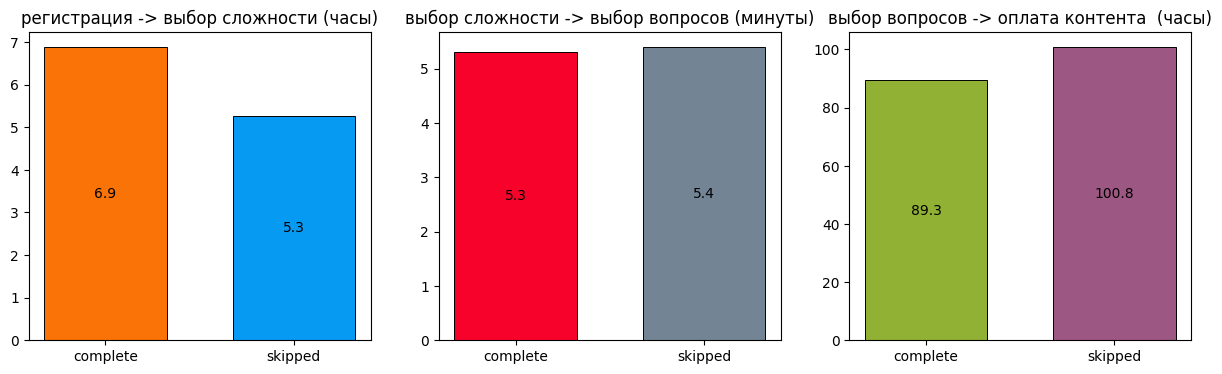

In [22]:
# строим столбчатые диаграммы по длительности 3 этапов, в разрезе обученности участников
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
barcolors = ['xkcd:orange', 'xkcd:azure']

# Рис. 1. регистрация -> выбор сложности
pic1 = axes[0].bar(x = pvt_tutorial_vs_time.index, 
                    height = pvt_tutorial_vs_time.level_choice_delay,
                    width = 0.65,
                    edgecolor="black", 
                    linewidth=0.7,
                    color = barcolors
                    )

axes[0].set_title('регистрация -> выбор сложности (часы)')
axes[0].bar_label(pic1, fmt='%.1f', label_type = 'center')

# Рис. 2. выбор сложности -> выбор вопросов 
barcolors = ['xkcd:cherry red', 'xkcd:steel']
pic2 = axes[1].bar(x = pvt_tutorial_vs_time.index, 
                    height = pvt_tutorial_vs_time.pack_choice_delay * 60,
                    width = 0.65,
                    edgecolor="black", 
                    linewidth=0.7,
                    color = barcolors
                    )
axes[1].set_title('выбор сложности -> выбор вопросов (минуты)')
axes[1].bar_label(pic2, fmt='%.1f', label_type = 'center')

# Рис. 3. выбор вопросов -> оплата контента
barcolors = ['xkcd:avocado', 'xkcd:light plum']
pic3 = axes[2].bar(x = pvt_tutorial_vs_time.index, 
                    height = pvt_tutorial_vs_time.purchase_delay,
                    width = 0.65,
                    edgecolor="black", 
                    linewidth=0.7,
                    color = barcolors
                    )
axes[2].set_title('выбор вопросов -> оплата контента  (часы)')
axes[2].bar_label(pic3, fmt='%.1f', label_type = 'center')

plt.show()

Согласно полученным данным (3-й график), пользователи из группы прошедших обучение, принимают решение о покупке дополнительного контента быстрее, чем игнорировавшие обучение. Логично предположить, что неподготовленные пользователи имеют впоследствии затруднения с прохождением игры. 


Также обращает на себя внимание различное время (1-й график) от регистрации пользователя до выбора уровня сложности игры. Прошедшие обучение затрачивают времени на полтора часа больше необученных (время обучения здесь не учитывается). Возможно, материалы обучения вызывают вопросы у пользователя, ему требуется изучение дополнительных материалов, либо повторное обучение.  

Этап перехода от выбора уровня сложности к выбору пакета вопросов имеет очень короткий тайминг относительно игрового времени (2-й график), очевидно он не несет полезной информации для данного исследования.

<font color="green">Итак, факт обучения разнонаправленно влияет на время прохождения этапов игры для лояльных игроков. С одной стороны, он отдаляет время начала игры. С другой стороны, он существенно приближает принятие решения о покупке.</font >

## 4. Гипотеза 2. Зависимость вероятности оплаты от количества обучений.

*Проверить*, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь.

### 4.1. Группировка данных в таблицы


Фактически, нам необходимо сформировать две таблицы с группами пользователей, содержимое которых и даст ответ, верна ли гипотеза:
- "количество начавших обучение N раз" - "количество оплат от этой группы";
- "количество завершивших обучение N раз" - "количество оплат от этой группы".

In [23]:
# Создаем временные датафреймы, для последующей консолидации в группы пользователей:

# tutorial_events - копия датафрейма игровых событий event_df, с усеченным набором столбцов
tutorial_events = event_df.drop(['event_id',
                                 'selected_level',
                                 'start_time'],
                                 axis=1)

# tutorial_starters - датафрейм с количеством событий "начало обучения" по каждому пользователю
tutorial_starters = tutorial_events.groupby(by='user_id')['tutorial_id'].nunique().reset_index()
tutorial_starters.columns = ['user_id','started']

# tutorial_graduated  - датафрейм с количеством событий "завершение обучения" по каждому пользователю
tutorial_graduated = tutorial_events[
                    tutorial_events.event_type=='tutorial_finish'
                    ].groupby(by='user_id')['tutorial_id'].nunique().reset_index()
tutorial_graduated.columns = ['user_id','finished']

# purchase_events - датафрейм с количеством оплат по каждому пользователю
purchase_events = purch_df.drop(['event_type','start_time','amount'],axis=1)
purchase_events = purchase_events.groupby(by='user_id')['purchase_id'].nunique().reset_index()
purchase_events.columns = ['user_id','purchased']

In [24]:
# к данным по количеству событий обучения пользователей добавляем данные по количеству оплат:

# starters_pack - количество событий "начало обучения" плюс количество оплат по каждому пользователю
starters_pack = pd.merge(tutorial_starters, purchase_events, how='left', on='user_id').fillna(0)
# graduated_pack - количество событий "завершение обучения" плюс количество оплат по каждому пользователю
graduated_pack = pd.merge(tutorial_graduated, purchase_events, how='left', on='user_id').fillna(0)

# консолидируем эти таблицы в группы пользователей, в зависимости от количества
# игровых событий "начало обучения"/"завершение обучения". 
# Получаем требуемые для проверки гипотезы две таблицы.
starters_pack = starters_pack.groupby('started')['purchased'].sum()
graduated_pack = graduated_pack.groupby('finished')['purchased'].sum()

### 4.2. Оформление результатов, выводы 

In [25]:
# найдем верхнее значение показателей, для масштабирования оси Y
y_top = max(starters_pack.values.max(), graduated_pack.values.max())

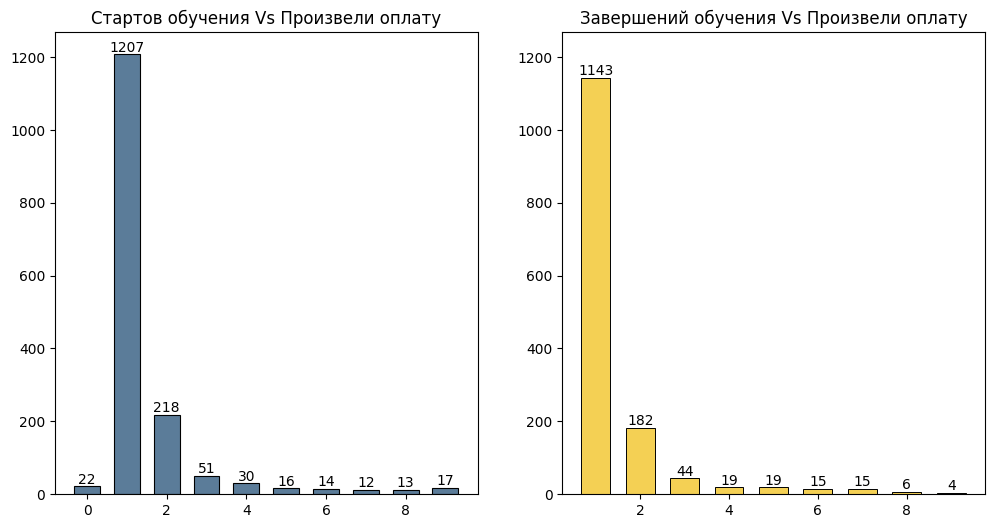

In [26]:
# строим столбчатые диаграммы по длительности 3 этапов, в разрезе обученности участников

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Рис 1. Стартов обучения Vs Произвели оплату
pic1 = axes[0].bar(x = starters_pack.index, 
                    height = starters_pack.values,
                    width = 0.65,
                    edgecolor="black", 
                    linewidth=0.8,
                    color = 'xkcd:slate blue'
                    )

axes[0].set_title('Стартов обучения Vs Произвели оплату')
axes[0].bar_label(pic1, fmt='%d', label_type = 'edge')
axes[0].set_ylim(bottom=0, top=y_top*1.05)

# Рис 2. Завершений обучения Vs Произвели оплату
pic2 = axes[1].bar(x = graduated_pack.index, 
                    height = graduated_pack.values,
                    width = 0.65,
                    edgecolor="black", 
                    linewidth=0.7,
                    color = 'xkcd:maize'
                    )
axes[1].set_title('Завершений обучения Vs Произвели оплату')
axes[1].bar_label(pic2, fmt='%d', label_type = 'edge')
axes[1].set_ylim(bottom=0, top=y_top*1.05)

plt.show()

Первое, что можно отметить в полученных результатах - имеются случаи многократных запусков обучающего курса, максимальное количество - 9. Аналогичный "антирекорд" по количеству завершенных процессов обучения. Очевидно, что такие множественные попытки не являются нормой. 

В целом показатели у завершивших обучение и незакончивших похожи. Наиболее лояльной аудиторией являются однократно прошедшие/начавшие обучение. Необходимость вернуться к обучению повторно уменьшает вероятность оплаты приблизительно в 6 раз. Многократно начинавшие обучение (более 3 раз) имеют худшую лояльность, чем не обучавшиеся вовсе. 
Далее результаты несколько разнятся, у незакончивших небольшой взлет лояльности, а у завершивших - тренд исключительно понижающийся. Причину разницы можно объяснить тем, что начавшие получили в процессе обучения объяснение факта непрозрачности и вернулись к игровому процессу. Прошедшие же до конца обучения, скорее всего, не нашли ответов в очередной раз и утратили интерес к игре.

<font color="green">Итак, вероятность продать дополнительный контент для начавших обучение повторно стремительно падает с количеством возвратов к обучению.</font>

## 5. Гипотеза 3. Возвращаемость к обучению из игрового процесса

*Выяснить*, как часто пользователи начинают обучение после выбора уровня сложности. (Это позволит оценить прозрачность процесса взаимодействия с игрой: если пользователи после выбора уровня сложности обращаются к обучению, значит, работа с приложением непонятна.)

Для ответа на поставленный вопрос нужно выбрать игроков, у которых время самого позднего события 'tutorial_start' превышает время выбора уровня 'level_choice'. Далее найти долю таких игроков среди всех, выбравших уровень сложности. <br>
Игроков, которые еще не выбрали уровень сложности, в расчет не берем.

In [27]:
# Инициализируем маски, для выбора необходимых событий из датафрейма events_df
musk_A = event_df['event_type'] == 'level_choice'
musk_B = event_df['event_type'] == 'tutorial_start'

# формируем сводную таблицу с максимальными таймингами событий 'level_choice'
# и 'tutorial_start': 
# - строки - id пользователей
# - столбцы - виды событий
# - значения - максимальное время события
# отбрасываем игроков, у которых событие "выбор уровня сложности" отсутствует
pvt_bak2skul = event_df[musk_A|musk_B].pivot_table(index = 'user_id',
                                                columns = 'event_type',
                                                values = 'start_time',
                                                aggfunc = 'max').dropna(subset='level_choice')

In [28]:
# инициализируем маску отбора вернувшихся к обучению для сводной таблицы
musk_C = pvt_bak2skul['tutorial_start'] > pvt_bak2skul['level_choice']

# рассчитываем показатель возвращаемости к обучению
bak2skulers_ratio = len(pvt_bak2skul[musk_C]) / len(pvt_bak2skul)
print('Процент игроков, вернувшихся к обучению: {:.1%}'.format(bak2skulers_ratio))

Процент игроков, вернувшихся к обучению: 16.6%


## 6. Общие выводы

Влияние процесса обучения на игровой процесс в **Quiz Freeze** обнаружено значительным в контексте лояльности пользователей. *Обученные игроки "быстрее достают деньги" на платный контент*. Видится разумным стимулирование прохождения обучения игроками.

С другой стороны, имеются определенные проблемы с игровым процессом. Ряд пользователей (16,6%) возвращается к обучению. А, согласно полученным данным, этот возврат крайне негативно влияет на лояльность пользователей. Приблизительно, каждый шестой возвращается к обучению и только один из шести вернувшихся купит дополнительные вопросы. *Для значительной доли игроков игровой процесс непонятен, что ухудшает конверсию*.

Также стоит обратить внимание на сам процесс обучения. Он негативно влияет на вовлеченность игроков, поскольку отдаляет время начала игры, что несет риск утраты интереса. Помимо ревизии прозрачности игрового процесса, рекомендуется также провести аудит эргономики процесса обучения пользователей.